# Smartwatch Shoulder Project
Code adapted from OrthoTron's "ArmTrack" project.

## Import Libraries

In [1]:
import sys
sys.version

import os
import csv
import random
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.linalg import norm

In [2]:
# !pip uninstall scikit-learn -y
# !pip install -U scikit-learn

In [3]:
# import sklearn
from scipy import misc # scipy contains quaternion functions
# sklearn.__version__ # want most recent ver 1.3.2

## Madgwick Implementation
From Jonas Böer, [Madgwick filter Python implementation](https://github.com/morgil/madgwick_py)

This is a good [explanation](https://nitinjsanket.github.io/tutorials/attitudeest/madgwick#:~:text=The%20Madgwick%20filter%20formulates%20the,obtained%20by%20the%20accelerometer%20measurements.) of the filter

In [4]:
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import numpy as np
import numbers

class Quaternion:
    """
    A simple class implementing basic quaternion arithmetic.
    """
    def __init__(self, w_or_q, x=None, y=None, z=None):
        """
        Initializes a Quaternion object
        :param w_or_q: A scalar representing the real part of the quaternion, another Quaternion object or a
                    four-element array containing the quaternion values
        :param x: The first imaginary part if w_or_q is a scalar
        :param y: The second imaginary part if w_or_q is a scalar
        :param z: The third imaginary part if w_or_q is a scalar
        """
        self._q = np.array([1, 0, 0, 0])

        if x is not None and y is not None and z is not None:
            w = w_or_q
            q = np.array([w, x, y, z])
        elif isinstance(w_or_q, Quaternion):
            q = np.array(w_or_q.q)
        else:
            q = np.array(w_or_q)
            if len(q) != 4:
                raise ValueError("Expecting a 4-element array or w x y z as parameters")

        self.q = q

    # Quaternion specific interfaces

    def conj(self):
        """
        Returns the conjugate of the quaternion
        :rtype : Quaternion
        :return: the conjugate of the quaternion
        """
        return Quaternion(self._q[0], -self._q[1], -self._q[2], -self._q[3])

    def to_angle_axis(self):
        """
        Returns the quaternion's rotation represented by an Euler angle and axis.
        If the quaternion is the identity quaternion (1, 0, 0, 0), a rotation along the x axis with angle 0 is returned.
        :return: rad, x, y, z
        """
        if self[0] == 1 and self[1] == 0 and self[2] == 0 and self[3] == 0:
            return 0, 1, 0, 0
        rad = np.arccos(self[0]) * 2
        imaginary_factor = np.sin(rad / 2)
        if abs(imaginary_factor) < 1e-8:
            return 0, 1, 0, 0
        x = self._q[1] / imaginary_factor
        y = self._q[2] / imaginary_factor
        z = self._q[3] / imaginary_factor
        return rad, x, y, z

    @staticmethod
    def from_angle_axis(rad, x, y, z):
        s = np.sin(rad / 2)
        return Quaternion(np.cos(rad / 2), x*s, y*s, z*s)

    def to_euler_angles(self):
        pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
        if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
            roll = 0
            yaw = 2 * np.arctan2(self[1], self[0])
        elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
            roll = -2 * np.arctan2(self[1], self[0])
            yaw = 0
        else:
            roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
            yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
        return roll, pitch, yaw

    def to_euler123(self):
        roll = np.arctan2(-2 * (self[2] * self[3] - self[0] * self[1]), self[0] ** 2 - self[1] ** 2 - self[2] ** 2 + self[3] ** 2)
        pitch = np.arcsin(2 * (self[1] * self[3] + self[0] * self[1]))
        yaw = np.arctan2(-2 * (self[1] * self[2] - self[0] * self[3]), self[0] ** 2 + self[1] ** 2 - self[2] ** 2 - self[3] ** 2)
        return roll, pitch, yaw

    def __mul__(self, other):
        """
        multiply the given quaternion with another quaternion or a scalar
        :param other: a Quaternion object or a number
        :return:
        """
        if isinstance(other, Quaternion):
            w = self._q[0]*other._q[0] - self._q[1]*other._q[1] - self._q[2]*other._q[2] - self._q[3]*other._q[3]
            x = self._q[0]*other._q[1] + self._q[1]*other._q[0] + self._q[2]*other._q[3] - self._q[3]*other._q[2]
            y = self._q[0]*other._q[2] - self._q[1]*other._q[3] + self._q[2]*other._q[0] + self._q[3]*other._q[1]
            z = self._q[0]*other._q[3] + self._q[1]*other._q[2] - self._q[2]*other._q[1] + self._q[3]*other._q[0]

            return Quaternion(w, x, y, z)
        elif isinstance(other, numbers.Number):
            q = self._q * other
            return Quaternion(q)

    def __add__(self, other):
        """
        add two quaternions element-wise or add a scalar to each element of the quaternion
        :param other:
        :return:
        """
        if not isinstance(other, Quaternion):
            if len(other) != 4:
                raise TypeError("Quaternions must be added to other quaternions or a 4-element array")
            q = self._q + other
        else:
            q = self._q + other._q

        return Quaternion(q)

    # Implementing other interfaces to ease working with the class

    @property
    def q(self):
        return self._q

    @q.setter
    def q(self, q):
        self._q = q

    def __getitem__(self, item):
        return self._q[item]

    def __array__(self):
        return self._q

In [5]:
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import warnings
# import numpy as np
from numpy.linalg import norm
# from .quaternion import Quaternion

class MadgwickAHRS:
    samplePeriod = 1/256
    quaternion = Quaternion(1, 0, 0, 0)
    beta = 1
    zeta = 0

    def __init__(self, sampleperiod=None, quaternion=None, beta=None, zeta=None):
        """
        Initialize the class with the given parameters.
        :param sampleperiod: The sample period
        :param quaternion: Initial quaternion
        :param beta: Algorithm gain beta
        :param beta: Algorithm gain zeta
        :return:
        """
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta
        if zeta is not None:
            self.zeta = zeta

    def update(self, gyroscope, accelerometer, magnetometer):
        """
        Perform one update step with data from a AHRS sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        :param magnetometer: A three-element array containing the magnetometer data. Can be any unit since a normalized value is used.
        :return:
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        b = np.array([0, norm(h[1:3]), 0, h[3]])

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
            2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
            2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
            2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        ])
        j = np.array([
            [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
            [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
            [0,                        -4*q[1],                 -4*q[2],                  0],
            [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
            [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
            [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Gyroscope compensation drift
        gyroscopeQuat = Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])
        stepQuat = Quaternion(step.T[0], step.T[1], step.T[2], step.T[3])

        gyroscopeQuat = gyroscopeQuat + (q.conj() * stepQuat) * 2 * self.samplePeriod * self.zeta * -1

        # Compute rate of change of quaternion
        qdot = (q * gyroscopeQuat) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

    def update_imu(self, gyroscope, accelerometer):
        """
        Perform one update step with data from a IMU sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data. Can be any unit since a normalized value is used.
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion

<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-4d79a34b7757>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(accelerometer) is 0:
<ipython-input-5-4d79a34b7757>:68: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(magnetometer) is 0:
<ipython-input-5-4d79a34b7757>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if norm(accelerometer) is 0:


## Dataloader

In [6]:
class DataLoader:
  def __init__(self, dataset,
               time_col="time",
               accel_col=['a_1','a_2','a_3'],
               gyro_col=['g_1','g_2','g_3'],
               magnet_col=['m_1','m_2','m_3']):
    """
    Initialize dataloader for recorded motion IMU data

    Passed in dataset should be in the form of a pandas dataframe, with the
    columns:
        time_col: the column with the time since start [s]
        accel_col: the column for the recorded accelerometer data
                   (tuple of x, y, z axes)
        gyro_col: the column for the recorded gyroscope data
                   (tuple of x, y, z axes)
        magnet_col: the column for the recorded magnetometer data
                   (tuple of x, y, z axes)

    At each iteration, the iterator returns a row in the form of a named tuple
    corresponding to a measurement for each sensor.
    The format of the data returned is:
        [x,y,z]: x,y,z measurements for indices [0, 1, 2], respectively
    """
    df_copy = dataset.copy(deep=True)
    df_copy = df_copy.rename(columns={time_col: "t"})
    df_copy.sort_values(by=["t"])

    self.time_data = iter(df_copy["t"])

    self.accel_data = df_copy[accel_col].itertuples(index=False, name="Accelerometer")

    self.gyro_data = df_copy[gyro_col].itertuples(index=False, name="Gyroscope")

    self.magnet_data = df_copy[magnet_col].itertuples(index=False, name="Magnetometer")

  def __iter__(self):
    return self

  def __next__(self):
    """Returns the next values of acceleration, gyroscope, and magnetometer"""

    a = next(self.accel_data, None)
    g = next(self.gyro_data, None)
    m = next(self.magnet_data, None)
    t = next(self.time_data, None)

    if a is None or g is None or m is None:
      raise StopIteration

    t_next = t
    a_next = np.array([a[0], a[1], a[2]]).reshape(3,1)
    g_next = np.array([g[0], g[1], g[2]]).reshape(3,1)
    m_next = np.array([m[0], m[1], m[2]]).reshape(3,1)

    return t_next, g_next, a_next, m_next

## Orientation Estimation Using Madgwick Filter

**Note**: The quaternions from the Madgwick filter represent the estimated Earth reference frame in the sensor's frame of reference

In [7]:
# By Vignesh Sivan

from scipy.spatial.transform import Rotation as R

def setup_madgwick(sampleperiod, initial_orientation=None, beta=None):
  """ The main purpose of this function is to return a closure """
  io = initial_orientation if initial_orientation is not None else Quaternion(1, 0, 0, 0)
  b = beta if beta is not None else 1
  madgwick = MadgwickAHRS(sampleperiod, io, b)

  def rawdata2_quaternion(g,a,m=None):
    """ Expects an iterable containing raw data at each time step """
    if m is not None:
      madgwick.update(g,a,m)
    else:
      madgwick.update_imu(g,a)
    q_se = madgwick.quaternion
    return q_se

  return rawdata2_quaternion

In [8]:
GRAVITY = -9.81 # Not used
SAMPLING_FREQUENCY = 50 # [Hz], assume samplied frequency of 50 Hz
SAMPLING_PERIOD = 1/SAMPLING_FREQUENCY # [s] For the IMU data

## Pre-processing Data
Define functions to filter the sensor measurements of a given trial data set.

In [9]:
# Save data into a csv
from pathlib import Path

def save_MF_data(df_temp, filename_temp, filepath_temp):
    from datetime import date
    date_temp = f"{date.today()}"

    folder_path = os.path.join(filepath_temp, date_temp)

    Path(folder_path).mkdir(parents=True, exist_ok=True)
    df_temp.to_csv(f"{filepath_temp}/{date_temp}/{filename_temp}_MF_imu.csv") # Rename file as needed

In [10]:
def apply_madgwick_filter(df_temp):
    '''Applies the Madgwick filter to the accelerometer, gyroscope, and
    magnetometer data '''
    orientation_temp = setup_madgwick(SAMPLING_PERIOD) # use 1/50 Hz
    time_temp        = [t for t,_,_,_ in DataLoader(df_temp)]
    quaternions_temp = [orientation_temp(g,a,m) for _,g,a,m in DataLoader(df_temp)] # Result from the madgwick filter
    acc_sensor_temp  = [a.reshape(3) for _,_,a,_ in DataLoader(df_temp)]
    acc_earth_temp   = [(q*Quaternion([0, a[0], a[1], a[2]])*q.conj()).q[1:].reshape(3)\
                        for q,a in zip(quaternions_temp, acc_sensor_temp)]

    # print(acc_earth_temp)
    # print(f"size: {len(acc_earth_temp)}")

    # Seems like gravity was already factored in an earlier step
    # acc_earth_minus_gravity_temp = [a + np.array([0,0,GRAVITY]).reshape(3)\
    #                               for a in acc_earth_temp]

    gyro_sensor_temp  = [g.reshape(3) for _,g,_,_ in DataLoader(df_temp)]
    gryo_corrected   = [(q*Quaternion([0, g[0], g[1], g[2]])*q.conj()).q[1:].reshape(3)\
                        for q,g in zip(quaternions_temp, gyro_sensor_temp)]

    mag_sensor_temp  = [m.reshape(3) for _,_,_,m in DataLoader(df_temp)]
    mag_corrected   = [(q*Quaternion([0, m[0], m[1], m[2]])*q.conj()).q[1:].reshape(3)\
                        for q,m in zip(quaternions_temp, mag_sensor_temp)]

    # Combined sensors
    df_imu_temp = pd.DataFrame({'a_1': [x for x,_,_ in acc_earth_temp],
                                'a_2': [y for _,y,_ in acc_earth_temp],
                                'a_3': [z for _,_,z in acc_earth_temp],
                                'm_1': [x for x,_,_ in mag_corrected],
                                'm_2': [y for _,y,_ in mag_corrected],
                                'm_3': [z for _,_,z in mag_corrected],
                                'g_1': [x for x,_,_ in gryo_corrected],
                                'g_2': [y for _,y,_ in gryo_corrected],
                                'g_3': [z for _,_,z in gryo_corrected],
                                'time': time_temp})

    return df_imu_temp

## Reading Data and Applying Filter

In [11]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Reading in IMU data in the form of `[a_1, a_2, a_3, m_1, m_2, m_3, g_1, g_2, g_3, time]`

In [12]:
# Reading in single file, for sanity check

subject_num = '10'
exercise_num = 5
shoulder = 'R'
trial = 1

filename = f"S{subject_num}_E{exercise_num}_{shoulder}_{trial}"

# Reading in csv file
unfiltered_data = pd.read_csv(f"E:/Datasets/0-Processed_Datasets/subjects_2023-07-12/S{subject_num}_E{exercise_num}_{shoulder}_{trial}_full.csv")

df_unfiltered = unfiltered_data[['a_1', 'a_2', 'a_3', 'm_1', 'm_2', 'm_3', 'g_1', 'g_2', 'g_3', 'time']]

df_filtered = apply_madgwick_filter(df_unfiltered)

filepath = f"/content/drive/My Drive/Smartwatch-Shoulder-Project/Madgwick-Filtered/"
save_MF_data(df_filtered, filename, filepath) # save into csv

In [13]:
print("Unfiltered")
df_unfiltered

Unfiltered


,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,-0.349170,-1.343785,-0.582885,0.246276,0.859434,-0.023297,0.373542,1.391233,-0.079059,0.000000
1,-0.265823,-1.014442,-0.530941,0.257802,0.849659,-0.006553,0.049879,1.247065,-0.071898,0.020008
2,-0.329663,-0.865249,-0.545621,0.279538,0.834998,0.006005,-0.282557,1.173186,-0.062406,0.040017
3,-0.233017,-1.102376,-0.510616,0.292382,0.878982,0.043678,-0.177276,1.178188,-0.103872,0.060025
4,-0.131050,-1.022346,-0.306227,0.301273,0.864321,0.056236,-0.004478,1.238215,-0.146338,0.080034
...,...,...,...,...,...,...,...,...,...,...
2359,0.126083,-0.941328,-0.422537,-0.329055,0.795901,-0.144689,0.701020,0.548675,-0.117861,47.199966
2360,0.170416,-0.844501,-0.300581,-0.351779,0.791014,-0.173990,0.411497,0.737221,-0.213783,47.219975
2361,0.234256,-0.773363,-0.145879,-0.324115,0.781240,-0.190734,-0.216185,0.929615,-0.244758,47.239983
2362,0.153569,-0.857345,-0.081514,-0.296452,0.781240,-0.207478,-0.258526,1.065445,-0.287224,47.259992


In [14]:
print("Filtered")
df_filtered # See dataframe

Filtered


,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,-0.408907,-1.343513,-0.543325,0.270818,0.850923,-0.049066,0.411873,1.377425,-0.119892,0.000000
1,-0.360520,-1.017886,-0.464313,0.306537,0.830945,-0.063187,0.118530,1.237312,-0.133562,0.020008
2,-0.458131,-0.866678,-0.440479,0.350106,0.803208,-0.087645,-0.184549,1.187255,-0.128316,0.040017
3,-0.424869,-1.107618,-0.350608,0.393860,0.834513,-0.092011,-0.054394,1.175639,-0.212741,0.060025
4,-0.323753,-1.016559,-0.133913,0.425008,0.804633,-0.113632,0.144936,1.196510,-0.319325,0.080034
...,...,...,...,...,...,...,...,...,...,...
2359,-0.017615,0.172466,1.024928,0.519396,-0.004965,-0.702050,-0.230371,0.714158,-0.493226,47.199966
2360,-0.076295,0.120358,0.901258,0.529591,0.012138,-0.706478,0.059357,0.610598,-0.618203,47.219975
2361,-0.186701,0.081618,0.795442,0.499360,0.044627,-0.707399,0.502321,0.195624,-0.824761,47.239983
2362,-0.179934,-0.034456,0.855398,0.477689,0.064450,-0.713391,0.567246,0.206170,-0.959288,47.259992


Reading in all data and saving all data

In [15]:
# Define file structure as needed
FILE_TYPE = "full"
IMU_DATA_FOLDER = 'subjects_2023-07-12'
DIRECTORY_IMU = f'E:/Datasets/0-Processed_Datasets/{IMU_DATA_FOLDER}/' # Assuming this works, copied over

filepaths = []
filenames = [] # E.g. S01_E1_R_1_full.csv

df_all_trials = [] # Saving all input data trials into this

for f in os.listdir(DIRECTORY_IMU):
    if FILE_TYPE in f:
        filepaths.append(DIRECTORY_IMU + f)
        filenames.append(f)

filenames.sort()
filepaths.sort()

# Reading in csv files
for f in filepaths:
    df_all_trials.append(pd.read_csv(f))

# Taking the first half of the filename for saving in the future, e.g. S01_E1_R_1
filenames_short = []
for f in filenames:
    i_temp = f.rindex("_")
    filenames_short.append(f[0:i_temp])

filenames_short.sort()

# Read and apply Madgwick Filter to all files
SAVE_FILEPATH = f"E:/Datasets/0-Processed_Datasets/Madgwick-Filtered/" # Update if needed

for i in range(len(filenames)):
    imu_data = df_all_trials[i]

    df_imu = apply_madgwick_filter(imu_data)
    save_MF_data(df_imu, filenames_short[i], SAVE_FILEPATH) # save into csv

    print(f'\ni: {i}, {filenames_short[i]}')


i: 0, S01_E1_R_1

i: 1, S01_E1_R_2

i: 2, S01_E2_R_1

i: 3, S10_E5_R_1


## Data-Analysis
To validate the efficacy of the filter



In [16]:
# Get Statistics
def get_statistics(name, data):
    mean = statistics.mean(data)
    std = statistics.stdev(data)

    print(f'\n{name} average mean: {mean} +/- {std}')
    return mean, std

In [17]:
# After it's been filtered, look at the statistics over several trials of data
for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)


a_1 average mean: -0.03195822160272924 +/- 0.25851939320752737

a_2 average mean: -0.04381230016091205 +/- 0.2334012888649239

a_3 average mean: 1.1769342069862556 +/- 0.26216044651561093

m_1 average mean: 0.3842972965274482 +/- 0.13095778523997723

m_2 average mean: -0.005093348145539551 +/- 0.0999886451188739

m_3 average mean: -0.8006724461944986 +/- 0.1282147117949575

g_1 average mean: -0.02116075503428488 +/- 0.5534574111410353

g_2 average mean: 0.09805727882591743 +/- 0.491792422412883

g_3 average mean: 0.011930378633223658 +/- 1.1652446118156905


In [18]:
from matplotlib import pyplot as plt
from scipy.stats import norm

def plot_normal_distribution(name, data):
    mu, sd = norm.fit(data) # Fit normal distribution to data
    print(f'mean: {mu}, std: +/-{sd}')

    plt.hist(data, bins=20, density=True, alpha=0.6) # Histogram, alpha: transparency

    xmin, xmax = plt.xlim()
    x_axis = np.arange(xmin, xmax, 0.001)
    plt.axvline(x = mu, color = 'green', label = 'axvline - full height')

    plt.plot(x_axis, norm.pdf(x_axis, mu, sd), color='r') # PDF
    plt.ylabel('Density')
    plt.xlabel(name)
    plt.show()

mean: -0.031958221602729237, std: +/-0.2584647090412451


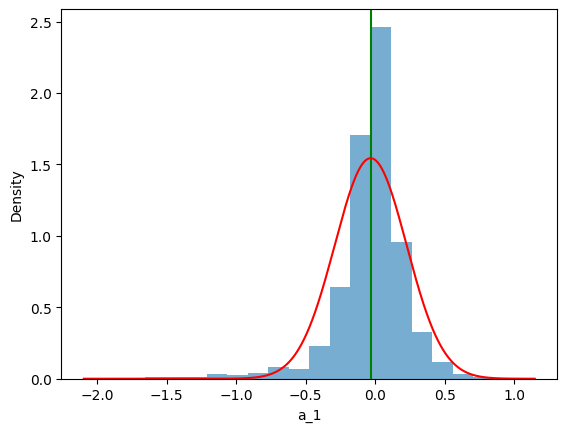

mean: -0.04381230016091205, std: +/-0.2333519178884086


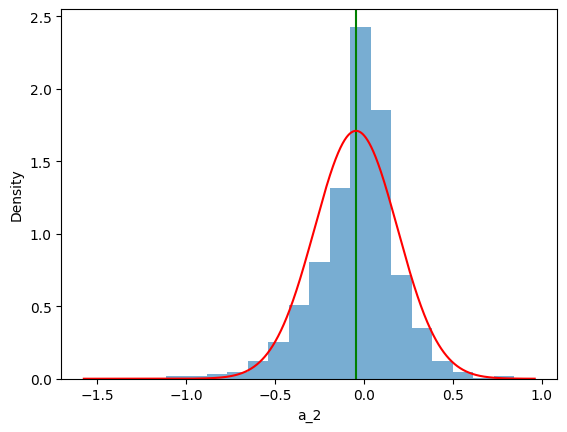

mean: 1.1769342069862556, std: +/-0.262104992163533


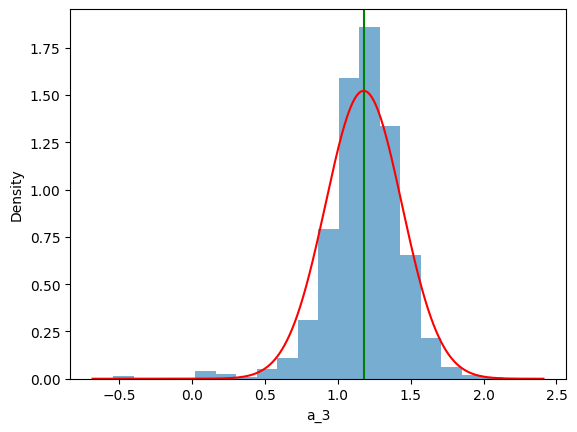

mean: 0.3842972965274482, std: +/-0.13093008396304331


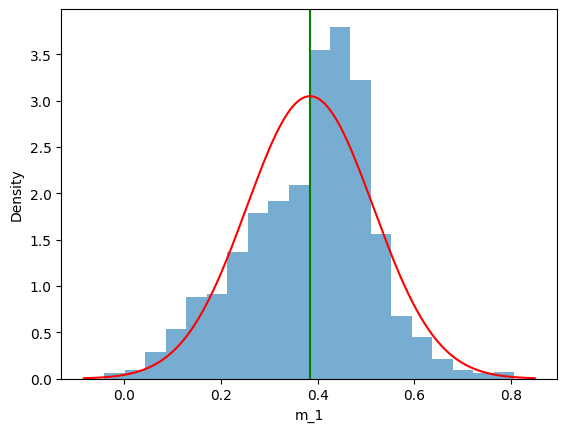

mean: -0.005093348145539553, std: +/-0.09996749469132499


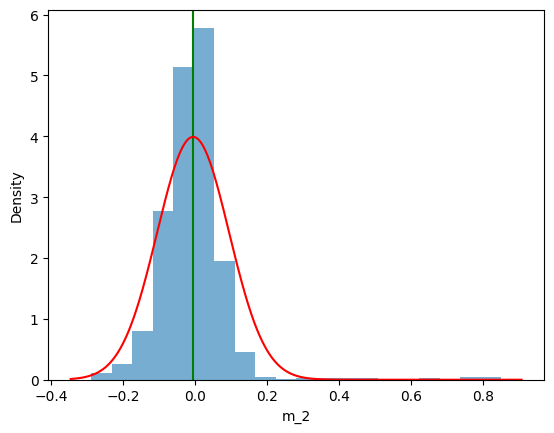

mean: -0.8006724461944986, std: +/-0.1281875907556705


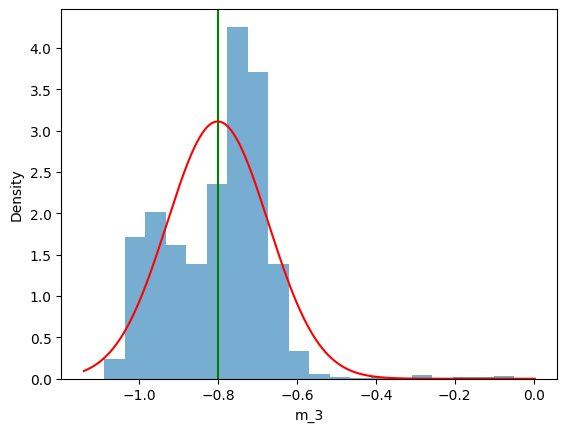

mean: -0.021160755034284887, std: +/-0.5533403392389026


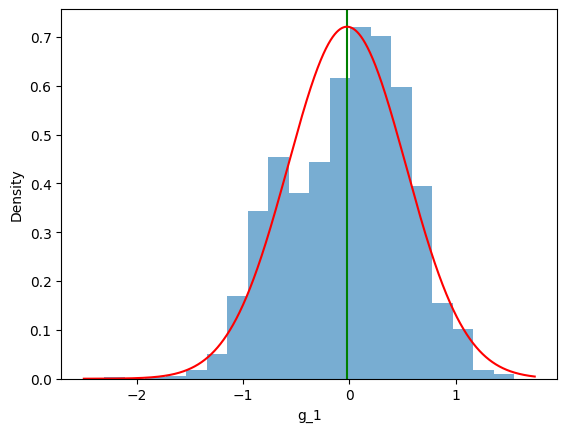

mean: 0.09805727882591743, std: +/-0.49168839440063244


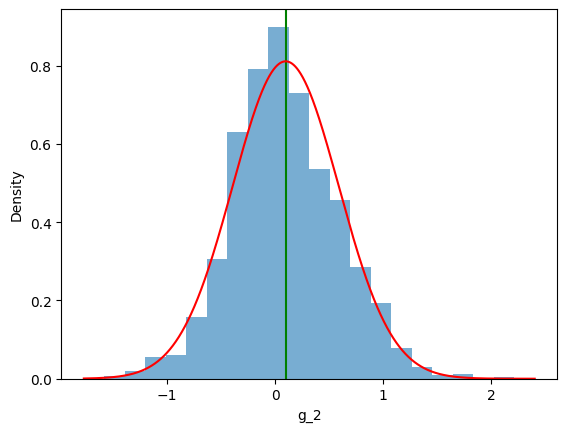

mean: 0.01193037863322366, std: +/-1.1649981296105396


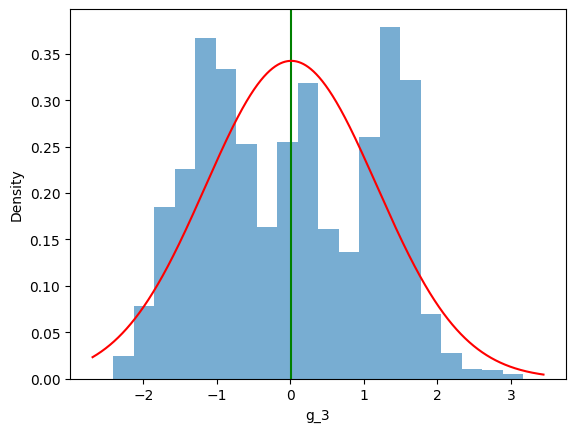

In [19]:
from matplotlib import pyplot as plt
from scipy.stats import norm

for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

### Time-series Visualization

In [21]:
def time_series_plot(sensor_type, data):
    prefix = sensor_type[0].lower()
    t = data['time']
    x = data[f'{prefix}_1']
    y = data[f'{prefix}_2']
    z = data[f'{prefix}_3']

    plt.figure(figsize=(10, 3))
    plt.plot(t, x, label='x')
    plt.plot(t, y, label='y')
    plt.plot(t, z, label='z')

    plt.title(sensor_type)
    plt.xlabel("time")
    plt.legend()
    plt.tight_layout()
    plt.show()

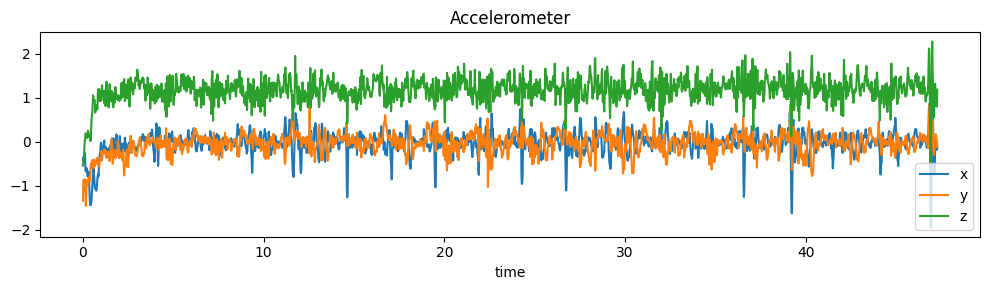

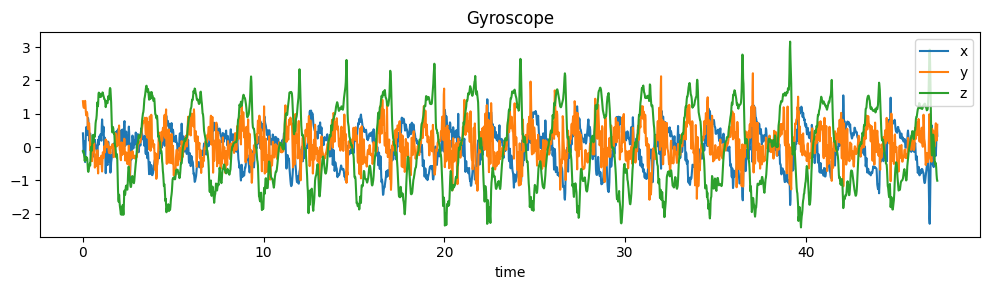

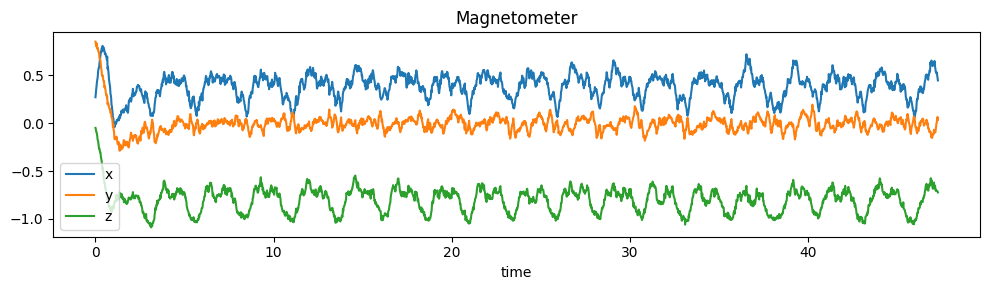

In [22]:
# df_sorted = df_filtered.sort_values('time', ascending=True)
time_series_plot('Accelerometer', df_filtered)
time_series_plot('Gyroscope', df_filtered)
time_series_plot('Magnetometer', df_filtered)

## Testing Notes

In [23]:
# Using full csv file - raw data is resampled here
    # After it's been filtered, look at the statistics over several trials of data: mean, std dev (normalization), plotting time series (notebooks to visualize 7?)

# Take in data from this format (below chart - specify column names)

# This notebook script will come after resampling (004 in the pre-processing data folder on GitHub)
# Will take inputs as the table below but just columns [a_1 to time]
# At this stage - seperate from mocap data; processed IMU data will be saved as a seperate file, will then be combined together with mocap after filtering
# Make an EKF version to compare with Madgwick filter outputs (plotting visualization time series to compare, should look similar)

# Look out for big jumps in data
# There are 2 exercises without accelerometer data, will be removed
# Want to assume fairly smooth data is input into the NN model
# data_original = pd.read_csv(f"/content/drive/My Drive/Smartwatch-Shoulder-Project/subjects_2023-07-12/S{subject_num}_E{exercise_num}_{shoulder}_{trial}_full.csv")
# data_original

# Coincidently, data_original == df_unfiltered from above
# imu_data_original = data_original[['a_1', 'a_2', 'a_3', 'm_1', 'm_2', 'm_3', 'g_1', 'g_2', 'g_3', 'time']]

,X,Y,Z,qx,qy,qz,qw,a_1,a_2,a_3,m_1,m_2,m_3,g_1,g_2,g_3,time
0,8.364253e-07,0.259516,0.043428,-0.079,0.050,0.992,0.084,-0.349170,-1.343785,-0.582885,0.246276,0.859434,-0.023297,0.373542,1.391233,-0.079059,0.000000
1,6.774692e-02,0.243298,0.047373,-0.083,0.049,0.993,0.064,-0.265823,-1.014442,-0.530941,0.257802,0.849659,-0.006553,0.049879,1.247065,-0.071898,0.020008
2,1.354930e-01,0.218971,0.051318,-0.091,0.047,0.994,0.045,-0.329663,-0.865249,-0.545621,0.279538,0.834998,0.006005,-0.282557,1.173186,-0.062406,0.040017
3,1.964645e-01,0.194643,0.055263,-0.085,0.046,0.995,0.023,-0.233017,-1.102376,-0.510616,0.292382,0.878982,0.043678,-0.177276,1.178188,-0.103872,0.060025
4,2.506614e-01,0.162207,0.059209,-0.078,0.046,0.996,0.001,-0.131050,-1.022346,-0.306227,0.301273,0.864321,0.056236,-0.004478,1.238215,-0.146338,0.080034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,-1.578483e+00,0.413589,0.027646,-0.069,0.023,0.871,0.486,0.126083,-0.941328,-0.422537,-0.329055,0.795901,-0.144689,0.701020,0.548675,-0.117861,47.199966
2360,-1.578483e+00,0.421698,0.031592,-0.073,0.019,0.872,0.484,0.170416,-0.844501,-0.300581,-0.351779,0.791014,-0.173990,0.411497,0.737221,-0.213783,47.219975
2361,-1.585258e+00,0.413589,0.031592,-0.076,0.016,0.870,0.487,0.234256,-0.773363,-0.145879,-0.324115,0.781240,-0.190734,-0.216185,0.929615,-0.244758,47.239983
2362,-1.598807e+00,0.397371,0.031592,-0.077,0.016,0.867,0.493,0.153569,-0.857345,-0.081514,-0.296452,0.781240,-0.207478,-0.258526,1.065445,-0.287224,47.259992


In [24]:
# Original, unfiltered
print('Original, unfiltered')

for name, data_series in df_unfiltered[df_unfiltered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)

Original, unfiltered

a_1 average mean: -0.019623944806194258 +/- 0.250167889612941

a_2 average mean: -1.090764006462156 +/- 0.1903227462525774

a_3 average mean: -0.44183180529351934 +/- 0.3065605851532026

m_1 average mean: 0.023057961595601816 +/- 0.2696941565896253

m_2 average mean: 0.8491047405412124 +/- 0.06847470501410055

m_3 average mean: -0.03787654130960746 +/- 0.1789759236129684

g_1 average mean: 0.0296697189307112 +/- 0.4071527079667577

g_2 average mean: -0.02777609069671298 +/- 1.302766714585444

g_3 average mean: 0.007514454791171863 +/- 0.22692757578923076


In [25]:
# After Madgwick Filter - is this directly comparable though? W.r.t exercise motion. I don't think it is.
print('After Madgwick Filter')

for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    _, _ = get_statistics(name, data_series)

After Madgwick Filter

a_1 average mean: -0.03195822160272924 +/- 0.25851939320752737

a_2 average mean: -0.04381230016091205 +/- 0.2334012888649239

a_3 average mean: 1.1769342069862556 +/- 0.26216044651561093

m_1 average mean: 0.3842972965274482 +/- 0.13095778523997723

m_2 average mean: -0.005093348145539551 +/- 0.0999886451188739

m_3 average mean: -0.8006724461944986 +/- 0.1282147117949575

g_1 average mean: -0.02116075503428488 +/- 0.5534574111410353

g_2 average mean: 0.09805727882591743 +/- 0.491792422412883

g_3 average mean: 0.011930378633223658 +/- 1.1652446118156905


Original, unfiltered
mean: -0.019623944806194258, std: +/-0.25011497202596866


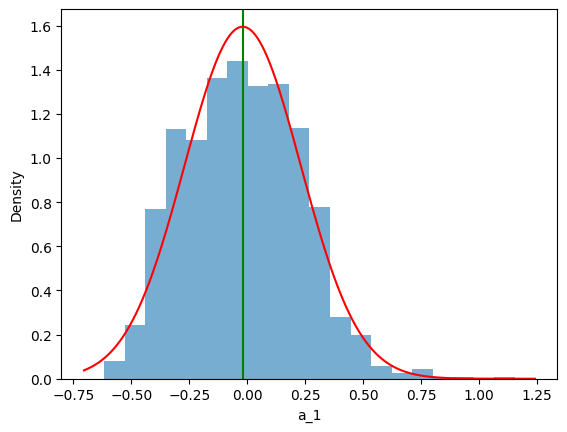

mean: -1.090764006462156, std: +/-0.19028248760670077


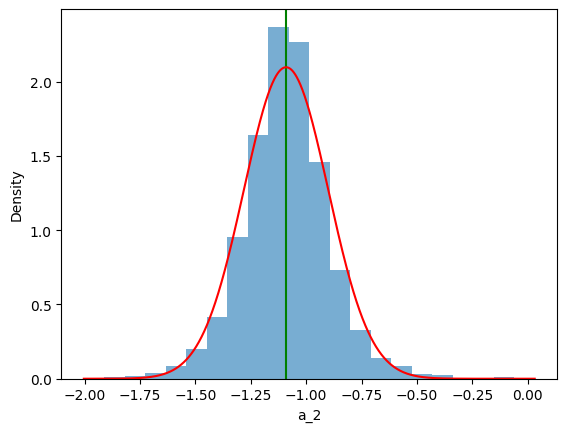

mean: -0.44183180529351923, std: +/-0.30649573891553306


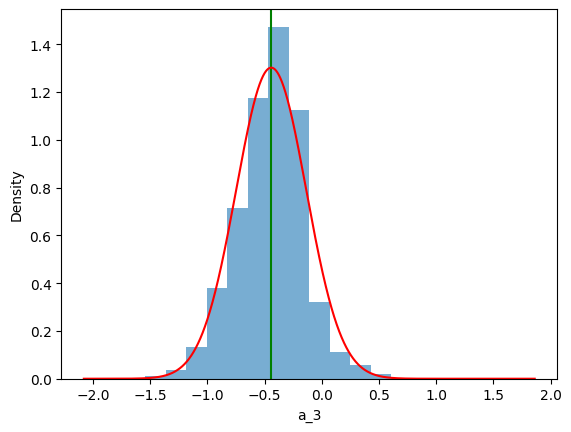

mean: 0.023057961595601823, std: +/-0.26963710864470586


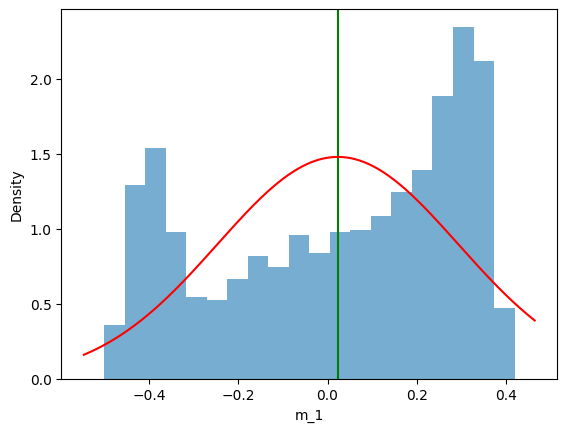

mean: 0.8491047405412125, std: +/-0.0684602206765479


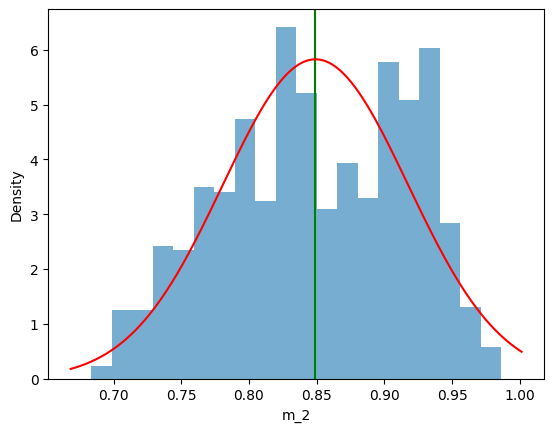

mean: -0.03787654130960746, std: +/-0.17893806514113017


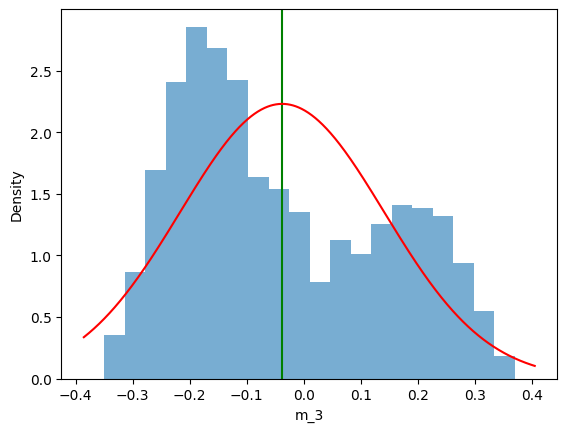

mean: 0.0296697189307112, std: +/-0.40706658364893183


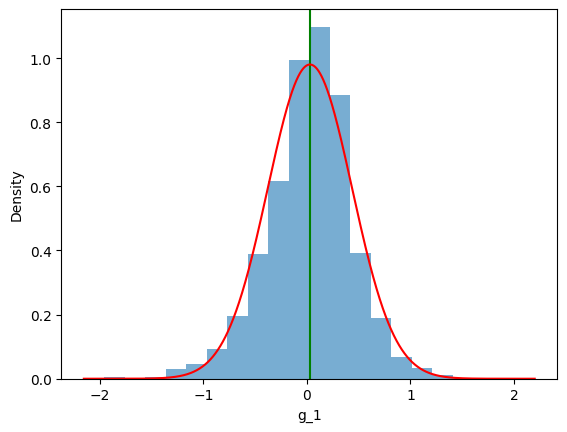

mean: -0.027776090696712993, std: +/-1.302491142564469


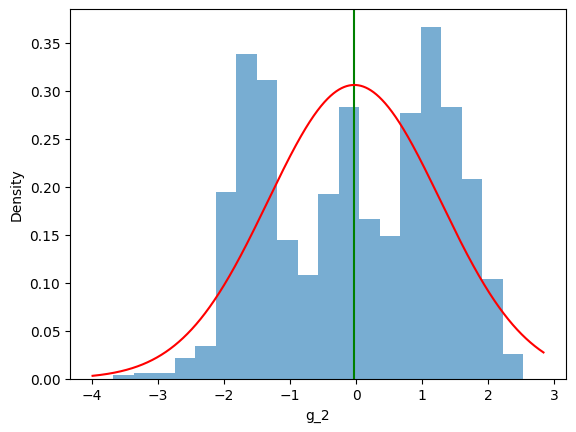

mean: 0.0075144547911718635, std: +/-0.2268795741862


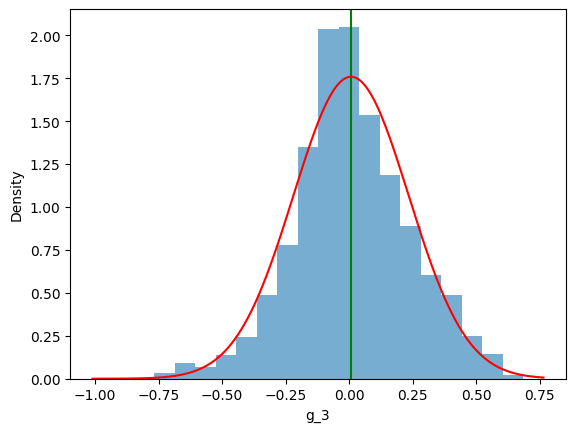

In [26]:
# Original, unfiltered
print('Original, unfiltered')

for name, data_series in df_unfiltered[df_unfiltered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

After Madgwick Filter
mean: -0.031958221602729237, std: +/-0.2584647090412451


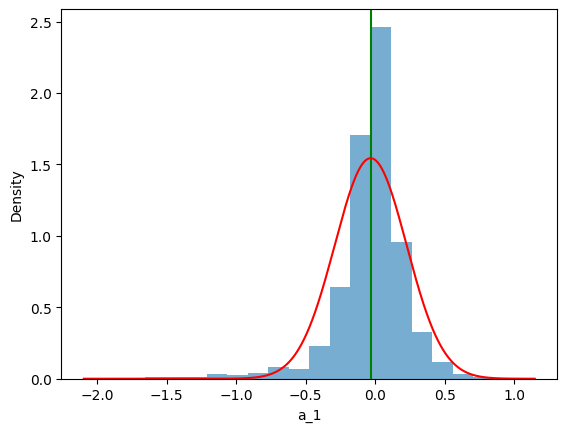

mean: -0.04381230016091205, std: +/-0.2333519178884086


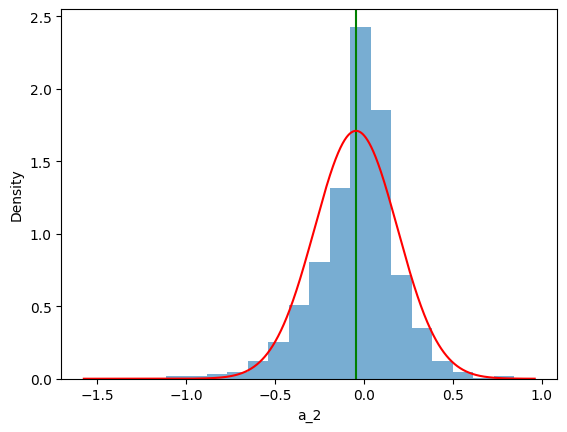

mean: 1.1769342069862556, std: +/-0.262104992163533


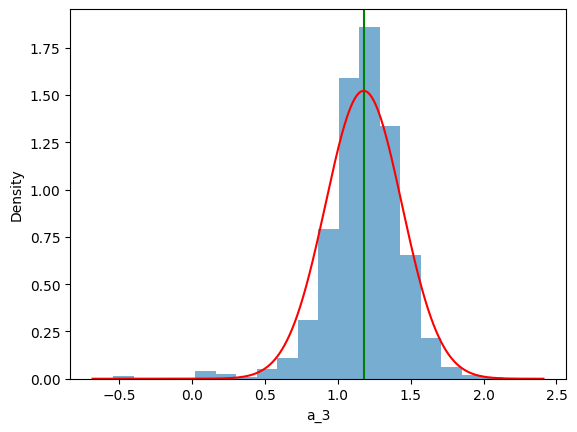

mean: 0.3842972965274482, std: +/-0.13093008396304331


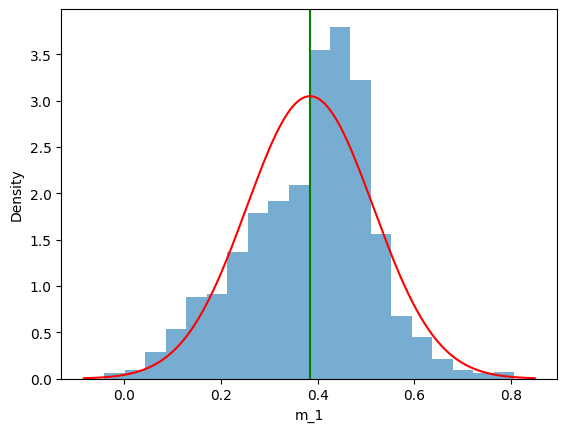

mean: -0.005093348145539553, std: +/-0.09996749469132499


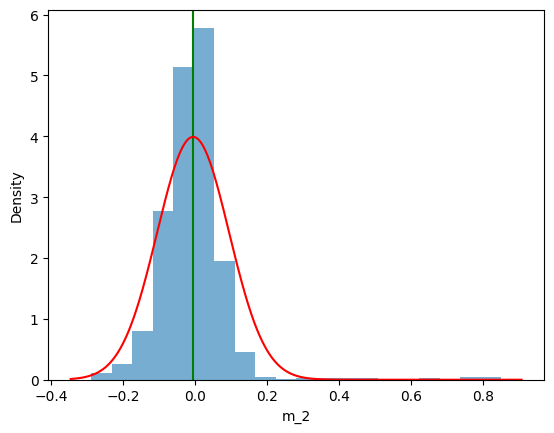

mean: -0.8006724461944986, std: +/-0.1281875907556705


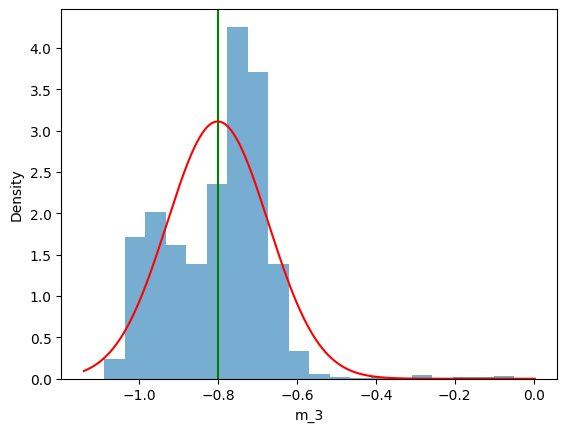

mean: -0.021160755034284887, std: +/-0.5533403392389026


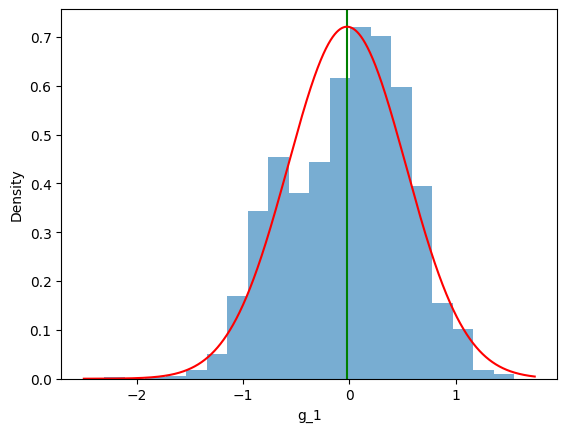

mean: 0.09805727882591743, std: +/-0.49168839440063244


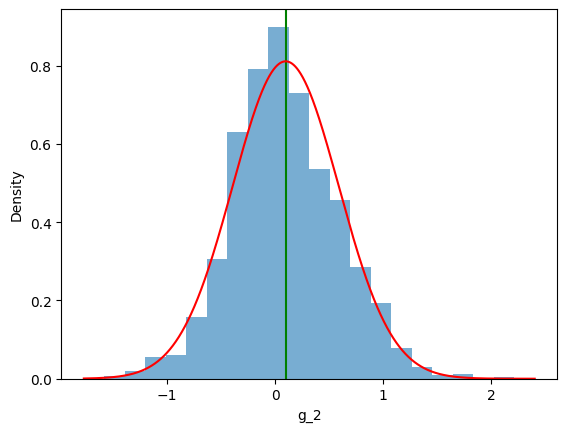

mean: 0.01193037863322366, std: +/-1.1649981296105396


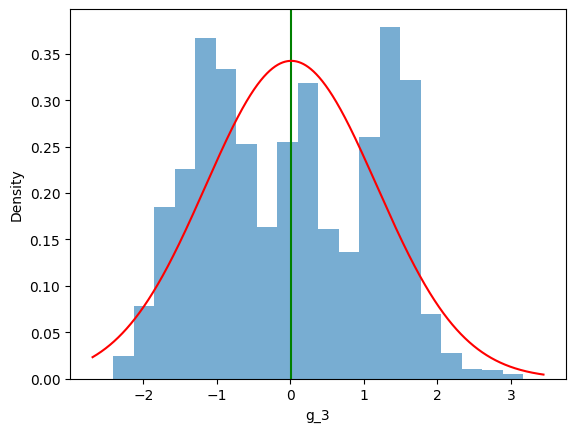

In [27]:
# After Madgwick Filter
print('After Madgwick Filter')

for name, data_series in df_filtered[df_filtered.columns[0:9]].items():
    plot_normal_distribution(name, data_series)

Unfiltered


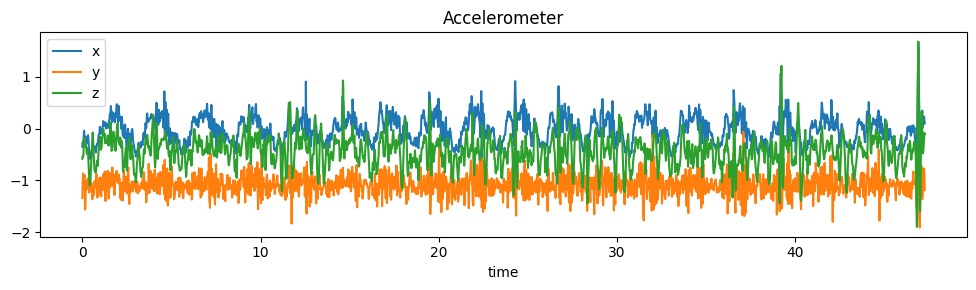

Filtered


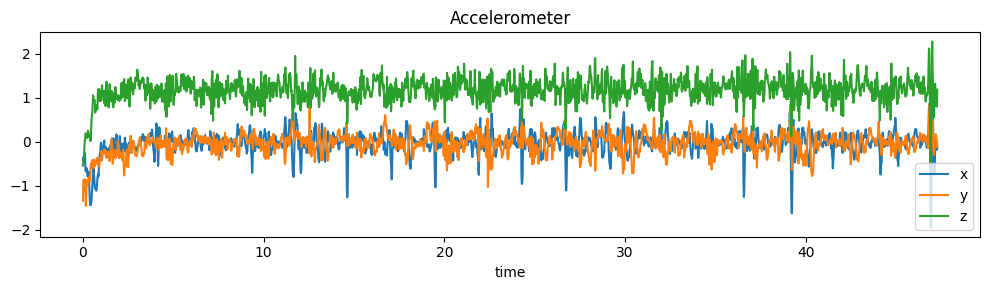

Unfiltered


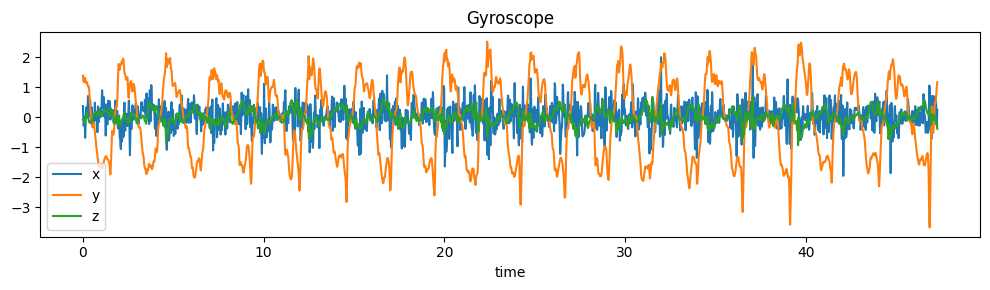

Filtered


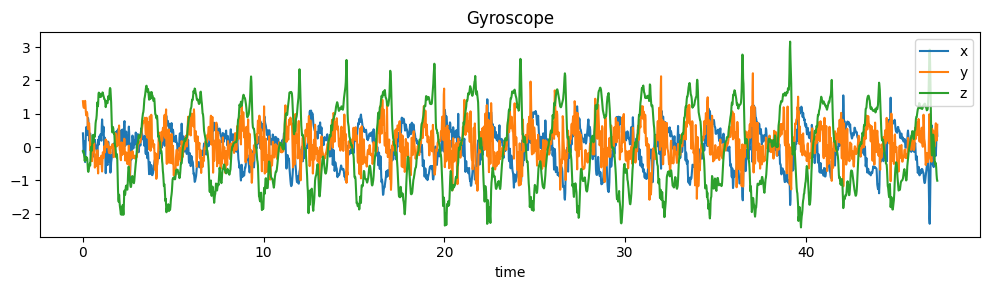

Unfiltered


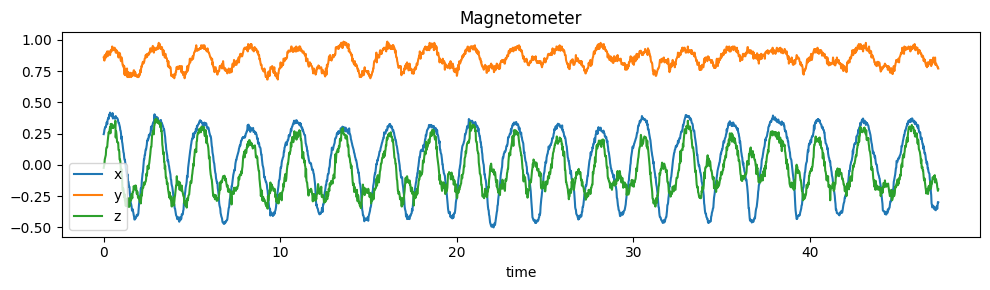

Filtered


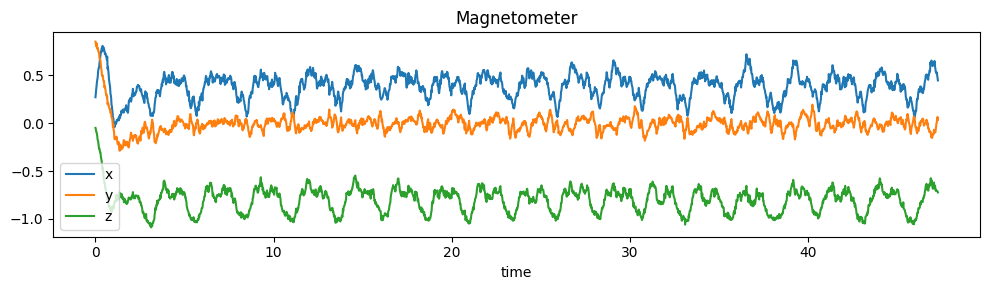

In [29]:
print('Unfiltered')
time_series_plot('Accelerometer', df_unfiltered)
print('Filtered')
time_series_plot('Accelerometer', df_filtered)
print('Unfiltered')
time_series_plot('Gyroscope', df_unfiltered)
print('Filtered')
time_series_plot('Gyroscope', df_filtered)
print('Unfiltered')
time_series_plot('Magnetometer', df_unfiltered)
print('Filtered')
time_series_plot('Magnetometer', df_filtered)

# Extended Kalman Filter (EKF)
[EKF GitHub](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/11-Extended-Kalman-Filters.ipynb)